In [1]:
import pandas as pd
import statsmodels.formula.api as smf

# todo - herdsize ~ livestock death
# livestock death ~ what is correlated with this
# create a dependent variable called any feed

In [2]:
df = pd.read_csv('../data/full_survey_data.csv')

/var/folders/b3/glj_22g92pl25nkdvjvxnzz00000gn/T/ipykernel_5787/4096187165.py:1: DtypeWarning: Columns (10,11,12,15,16,17,18,19,20,21,22,24,27,37,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,69,74,75,76,78,88,91,94,95,104,113,114,115,116,118,121,122,123,124,125,132,135,137,138,141,142,151,160,161,162,163,165,168,169,170,171,172,179,182,184,185,188,189,198,207,208,209,210,212,215,216,217,218,219,226,229,231,232,236,245,254,255,256,257,259,262,263,264,265,266,273,276,278,279,283,292,301,302,303,304,306,309,310,312,313,320,325,326,330,339,348,349,350,351,353,356,357,359,360,367,372,373,377,386,395,396,397,398,400,403,404,406,407,414,419,420,424,433,443,444,445,446,447,448,450,451,452,453,454,455,456,458,459,460,461,462,463,464,465,466,467,469,470,471,472,473,474,475,476,478,479,480,481,482,500,501,502,508,510,515,516,522,524,525,526,533,538,547,556,561,565,566,567,574,580,581,582,591,600,603,607,608,609,616,620,624,633,680,681,682,687,688,694,696,697,698,705,710

In [3]:
#  x ~ z
# creating the z variable and we only consider animals that potentially use crop residue as feed
# Step 1: Select relevant columns
name_cols = [f'livestock_name_{i}' for i in range(1, 6)]
died_cols = [f'livestock_died_{i}' for i in range(1, 6)]

# Step 2: Melt the livestock names and deaths
names_long = df.melt(id_vars='id_unique', value_vars=name_cols, 
                     var_name='animal_slot', value_name='livestock_name')

died_long = df.melt(id_vars='id_unique', value_vars=died_cols, 
                    var_name='animal_slot', value_name='livestock_died')

# Step 3: Make sure they align by extracting index number
names_long['slot'] = names_long['animal_slot'].str.extract(r'(\d+)').astype(int)
died_long['slot'] = died_long['animal_slot'].str.extract(r'(\d+)').astype(int)

# Step 4: Merge the two long DataFrames
long_df = pd.merge(
    names_long[['id_unique', 'slot', 'livestock_name']],
    died_long[['id_unique', 'slot', 'livestock_died']],
    on=['id_unique', 'slot']
)

# Optional: drop rows where animal name is missing
long_df = long_df.dropna(subset=['livestock_name']).reset_index(drop=True)

# Result: Each row is (id_unique, livestock_name, livestock_died)
print(long_df.head())

death_df = long_df[long_df.livestock_died.notna()]
 

         id_unique  slot livestock_name  livestock_died
0  bf_adn_2019_1_1     1          sheep             0.0
1  bf_adn_2019_2_1     1         cattle             0.0
2  bf_adn_2019_3_1     1           pigs             3.0
3  bf_adn_2019_4_1     1         cattle             0.0
4  bf_adn_2019_5_1     1         cattle             0.0


In [4]:
# List of animals to keep
animals_to_keep = ['cattle', 'chicken', 'goats', 'sheep', 'donkeys_horses', 'buffalo', 'pigs']

# Filter the DataFrame
final_death_df = death_df[death_df['livestock_name'].isin(animals_to_keep)]
final_death_df


,id_unique,slot,livestock_name,livestock_died
0,bf_adn_2019_1_1,1,sheep,0.0
1,bf_adn_2019_2_1,1,cattle,0.0
2,bf_adn_2019_3_1,1,pigs,3.0
3,bf_adn_2019_4_1,1,cattle,0.0
4,bf_adn_2019_5_1,1,cattle,0.0
...,...,...,...,...
81610,tz_glv_2017_156_1,5,donkeys_horses,0.0
81614,tz_glv_2017_522_1,5,pigs,0.0
81615,tz_glv_2017_562_1,5,donkeys_horses,0.0
81616,tz_glv_2017_889_1,5,chicken,3.0


In [5]:
# Sum livestock deaths per farm
deaths_by_farm = (
    final_death_df.groupby("id_unique")["livestock_died"]
    .sum()
    .reset_index(name="total_livestock_died")
)

deaths_by_farm.head()

,id_unique,total_livestock_died
0,bf_adn_2019_10_1,3.0
1,bf_adn_2019_11_1,5.0
2,bf_adn_2019_12_1,1.0
3,bf_adn_2019_13_1,3.0
4,bf_adn_2019_14_1,7.0


In [6]:
from scipy.stats.mstats import winsorize

# Extract the data column
values = deaths_by_farm["total_livestock_died"].values

# Winsorize only the top 5%
winsorized_values = winsorize(values, limits=(0, 0.05))

In [7]:
# Create a new column with the winsorized values
deaths_by_farm["winsorized_deaths"] = winsorized_values

In [8]:
deaths_by_farm

,id_unique,total_livestock_died,winsorized_deaths
0,bf_adn_2019_10_1,3.0,3.0
1,bf_adn_2019_11_1,5.0,5.0
2,bf_adn_2019_12_1,1.0,1.0
3,bf_adn_2019_13_1,3.0,3.0
4,bf_adn_2019_14_1,7.0,7.0
...,...,...,...
33063,zm_scn_2017_95_1,0.0,0.0
33064,zm_scn_2017_96_1,1.0,1.0
33065,zm_scn_2017_98_1,0.0,0.0
33066,zm_scn_2017_99_1,1.0,1.0


In [9]:
# creating herd_size and renaming livestock head columns to be more succint
# ['cattle', 'chicken', 'goats', 'sheep', 'donkeys_horses', 'buffalo', 'pigs']
livestock_heads_cols = [
    'livestock_heads_sheep',
    'livestock_heads_cattle',
    'livestock_heads_pigs',
    'livestock_heads_goats',
    'livestock_heads_chicken',
    'livestock_heads_buffalo',
    'livestock_heads_donkeys_horses'
]

# ok sum of heads to get herd_size
df['herd_size'] = df[livestock_heads_cols].sum(axis=1)

# # Create a rename mapping
# rename_dict = {
#     col: col.replace('livestock_heads_', '') + '_heads'
#     for col in df.columns if col.startswith('livestock_heads_')
# }

# # Apply the renaming
# df = df.rename(columns=rename_dict)

In [10]:
df[['herd_size','livestock_heads_sheep',
    'livestock_heads_cattle',
    'livestock_heads_pigs',
    'livestock_heads_goats',
    'livestock_heads_chicken',
    'livestock_heads_buffalo',
    'livestock_heads_donkeys_horses']].head(5)

,herd_size,livestock_heads_sheep,livestock_heads_cattle,livestock_heads_pigs,livestock_heads_goats,livestock_heads_chicken,livestock_heads_buffalo,livestock_heads_donkeys_horses
0,19.0,3.0,NaN,NaN,6.0,10.0,NaN,NaN
1,20.0,3.0,2.0,NaN,5.0,10.0,NaN,NaN
2,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,39.0,4.0,4.0,5.0,3.0,23.0,NaN,NaN
4,11.0,4.0,2.0,NaN,3.0,2.0,NaN,NaN


In [11]:
# Merge deaths_by_farm with herd_size from df using a left join on 'id_unique'
merged_df = deaths_by_farm.merge(df[['id_unique', 'herd_size']], on='id_unique', how='left')
merged_df.describe()

/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/nishantshrestha/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


,total_livestock_died,winsorized_deaths,herd_size
count,3.306800e+04,33068.000000,33068.000000
mean,1.324936e+02,3.002177,25.944508
std,2.200287e+04,5.359109,102.496922
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,4.000000
50%,0.000000e+00,0.000000,11.000000
75%,3.000000e+00,3.000000,24.000000
max,4.000000e+06,20.000000,10000.000000


,id_unique,total_livestock_died,winsorized_deaths,herd_size
8061,ci_arc_2018_44_1,0.0,0.0,5010.0
20169,ml_pra_2021_577_1,2.0,2.0,2001.0
24656,np_hef_2022_159_1,2001.0,20.0,5009.0
24714,np_hef_2022_214_1,202.0,20.0,2054.0
24730,np_hef_2022_22_1,1850.0,20.0,3010.0
30166,ug_crp_2020_500_1,1305.0,20.0,3703.0
30377,ug_crp_2020_70_1,40.0,20.0,10000.0
31572,vn_csi_2020_171_1,50.0,20.0,2513.0
31729,vn_nt1_2019_159_1,100.0,20.0,2020.0
32037,vn_nt3_2020_85_3,400.0,20.0,2002.0


In [15]:
# Extract the data column
values_1 = merged_df["herd_size"].values

# Winsorize only the top 5%
winsorized_values_1 = winsorize(values, limits=(0, 0.05))

<Axes: >

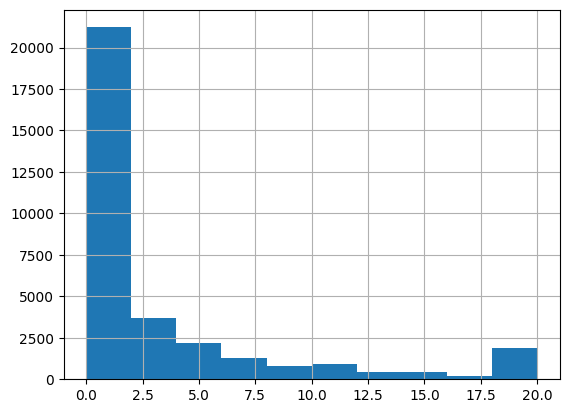

In [14]:
merged_df.winsorized_deaths.hist( )

<Axes: >

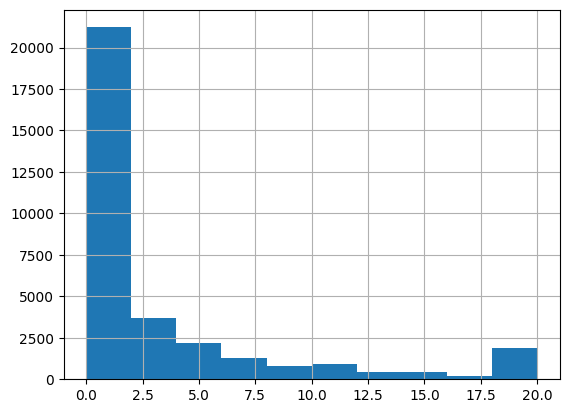

In [16]:
pd.Series(winsorized_values_1).hist()

In [26]:
# Create a new column with the winsorized values
merged_df["winsorized_herd_size"] = winsorized_values_1

In [32]:
merged_df

,id_unique,total_livestock_died,winsorized_deaths,herd_size,winsorized_herd_size
0,bf_adn_2019_10_1,3.0,3.0,25.0,25.0
1,bf_adn_2019_11_1,5.0,5.0,10.0,10.0
2,bf_adn_2019_12_1,1.0,1.0,6.0,6.0
3,bf_adn_2019_13_1,3.0,3.0,8.0,8.0
4,bf_adn_2019_14_1,7.0,7.0,61.0,61.0
...,...,...,...,...,...
33063,zm_scn_2017_95_1,0.0,0.0,6.0,6.0
33064,zm_scn_2017_96_1,1.0,1.0,23.0,23.0
33065,zm_scn_2017_98_1,0.0,0.0,28.0,28.0
33066,zm_scn_2017_99_1,1.0,1.0,18.0,18.0


In [ ]:
print("\n--- Base Model ---")
model = smf.ols(
    formula="winsorized_herd_size ~ winsorized_deaths",
    data=merged_df
).fit()
print(model.summary()) # add country and time FEs


--- Base Model ---
                             OLS Regression Results                             
Dep. Variable:     winsorized_herd_size   R-squared:                       0.152
Model:                              OLS   Adj. R-squared:                  0.152
Method:                   Least Squares   F-statistic:                     5942.
Date:                  Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                          22:22:02   Log-Likelihood:            -1.4363e+05
No. Observations:                 33068   AIC:                         2.873e+05
Df Residuals:                     33066   BIC:                         2.873e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [34]:
merged_df['winsorized_herd_size'].corr(merged_df['winsorized_deaths'])

0.3902862272956717

In [35]:
merged_df.to_csv('../data/merged_deaths_herd_size.csv', index=False)

In [9]:
deaths_by_farm

,id_unique,total_livestock_died,winsorized_deaths
0,bf_adn_2019_10_1,3.0,3.0
1,bf_adn_2019_11_1,5.0,5.0
2,bf_adn_2019_12_1,1.0,1.0
3,bf_adn_2019_13_1,3.0,3.0
4,bf_adn_2019_14_1,7.0,7.0
...,...,...,...
33063,zm_scn_2017_95_1,0.0,0.0
33064,zm_scn_2017_96_1,1.0,1.0
33065,zm_scn_2017_98_1,0.0,0.0
33066,zm_scn_2017_99_1,1.0,1.0


In [ ]:
# crop count
# count people
#crop_storage_treatment_yn
#land_irrigated

In [17]:
df.offfarm_incomes_any.value_counts()

offfarm_incomes_any
n            28852
y            21530
TRUE           498
FALSE          438
no_answer       51
Name: count, dtype: int64

In [18]:
df.male_adult_off_farm_source_prop_1.value_counts()

male_adult_off_farm_source_prop_1
1.000000    6846
0.500000    5872
0.000000    5735
0.333333     162
0.250000     120
0.200000       8
Name: count, dtype: int64

In [10]:
df[['male_adult_off_farm_source_prop_1',
    'male_youth_off_farm_source_prop_1',
    'female_adult_off_farm_source_prop_1',
    'female_youth_off_farm_source_prop_1']]

,male_adult_off_farm_source_prop_1,male_youth_off_farm_source_prop_1,female_adult_off_farm_source_prop_1,female_youth_off_farm_source_prop_1
0,0.0,0.0,1.0,0.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,0.0,0.0,1.0,0.0
4,NaN,NaN,NaN,NaN
...,...,...,...,...
54868,NaN,NaN,NaN,NaN
54869,NaN,NaN,NaN,NaN
54870,0.5,0.0,0.5,0.0
54871,1.0,0.0,0.0,0.0


In [12]:
df[['crop_count','count_people','crop_storage_treatment_yn','land_irrigated','debts_have']]

,crop_count,count_people,crop_storage_treatment_yn,land_irrigated,debts_have
0,3.0,7.0,NaN,n,n
1,2.0,10.0,NaN,n,n
2,2.0,6.0,NaN,n,y
3,3.0,6.0,NaN,n,n
4,3.0,8.0,NaN,n,n
...,...,...,...,...,...
54868,4.0,NaN,y,n,n
54869,3.0,NaN,y,n,n
54870,3.0,NaN,n,n,n
54871,2.0,NaN,y,n,n


In [13]:
# Crop count
merged_farm_df = deaths_by_farm.merge(
    df[["id_unique", "crop_count"]],
    on="id_unique",
    how="left"
)


# Food shortage time
merged_farm_df = merged_farm_df.merge(
    df[["id_unique", "crop_storage_treatment_yn"]],
    on="id_unique",
    how="left"
)

# Debts have
merged_farm_df = merged_farm_df.merge(
    df[["id_unique", "debts_have"]],
    on="id_unique",
    how="left"
)

# Count people
merged_farm_df = merged_farm_df.merge(
    df[["id_unique", "count_people"]],
    on="id_unique",
    how="left"
)

# irrigated land or no
merged_farm_df = merged_farm_df.merge(
    df[["id_unique", "land_irrigated"]],
    on="id_unique",
    how="left"
)

# harvest early
merged_farm_df = merged_farm_df.merge(
    df[["id_unique", "harvest_early"]],
    on="id_unique",
    how="left"
)

# food shortage
merged_farm_df = merged_farm_df.merge(
    df[["id_unique", "foodshortagetime"]],
    on="id_unique",
    how="left"
)

In [14]:
merged_farm_df

,id_unique,total_livestock_died,winsorized_deaths,crop_count,crop_storage_treatment_yn,debts_have,count_people,land_irrigated,harvest_early,foodshortagetime
0,bf_adn_2019_10_1,3.0,3.0,3.0,NaN,n,9.0,n,y,y
1,bf_adn_2019_11_1,5.0,5.0,3.0,NaN,n,8.0,n,n,y
2,bf_adn_2019_12_1,1.0,1.0,3.0,NaN,n,6.0,n,n,y
3,bf_adn_2019_13_1,3.0,3.0,3.0,NaN,n,6.0,n,y,y
4,bf_adn_2019_14_1,7.0,7.0,3.0,NaN,n,12.0,n,n,y
...,...,...,...,...,...,...,...,...,...,...
33063,zm_scn_2017_95_1,0.0,0.0,1.0,y,n,NaN,y,n,n
33064,zm_scn_2017_96_1,1.0,1.0,3.0,y,y,NaN,n,n,y
33065,zm_scn_2017_98_1,0.0,0.0,1.0,y,y,NaN,n,n,y
33066,zm_scn_2017_99_1,1.0,1.0,1.0,n,y,NaN,n,n,y


In [15]:
for col in ["harvest_early", "foodshortagetime", "debts_have","crop_storage_treatment_yn", "land_irrigated"]:
    merged_farm_df[col] = merged_farm_df[col].map({"y": 1, "n": 0})
merged_farm_df

,id_unique,total_livestock_died,winsorized_deaths,crop_count,crop_storage_treatment_yn,debts_have,count_people,land_irrigated,harvest_early,foodshortagetime
0,bf_adn_2019_10_1,3.0,3.0,3.0,NaN,0.0,9.0,0.0,1.0,1.0
1,bf_adn_2019_11_1,5.0,5.0,3.0,NaN,0.0,8.0,0.0,0.0,1.0
2,bf_adn_2019_12_1,1.0,1.0,3.0,NaN,0.0,6.0,0.0,0.0,1.0
3,bf_adn_2019_13_1,3.0,3.0,3.0,NaN,0.0,6.0,0.0,1.0,1.0
4,bf_adn_2019_14_1,7.0,7.0,3.0,NaN,0.0,12.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
33063,zm_scn_2017_95_1,0.0,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0
33064,zm_scn_2017_96_1,1.0,1.0,3.0,1.0,1.0,NaN,0.0,0.0,1.0
33065,zm_scn_2017_98_1,0.0,0.0,1.0,1.0,1.0,NaN,0.0,0.0,1.0
33066,zm_scn_2017_99_1,1.0,1.0,1.0,0.0,1.0,NaN,0.0,0.0,1.0


In [16]:
correlations = merged_farm_df.corr(numeric_only=True)['total_livestock_died'].drop('total_livestock_died')
print(correlations)

winsorized_deaths            0.018911
crop_count                  -0.001940
crop_storage_treatment_yn    0.009508
debts_have                  -0.004205
count_people                -0.003421
land_irrigated               0.011571
harvest_early               -0.003618
foodshortagetime             0.003817
Name: total_livestock_died, dtype: float64


In [18]:
correlations = merged_farm_df.corr(numeric_only=True)['winsorized_deaths'].drop('winsorized_deaths')
print(correlations)

total_livestock_died         0.018911
crop_count                   0.091909
crop_storage_treatment_yn   -0.037748
debts_have                   0.034176
count_people                 0.032086
land_irrigated               0.008604
harvest_early               -0.021617
foodshortagetime            -0.050186
Name: winsorized_deaths, dtype: float64


In [22]:
non_diff_rows = merged_farm_df[merged_farm_df['winsorized_deaths'] == merged_farm_df['total_livestock_died']]
non_diff_rows.corr(numeric_only=True)['winsorized_deaths'].drop('winsorized_deaths')

total_livestock_died         1.000000
crop_count                   0.095163
crop_storage_treatment_yn   -0.015412
debts_have                   0.009685
count_people                 0.028909
land_irrigated              -0.009913
harvest_early               -0.025492
foodshortagetime            -0.020450
Name: winsorized_deaths, dtype: float64

In [23]:
# Create a list for all crop_name and crop_residue_use columns
crop_cols = [f"crop_name_{i}" for i in range(1, 9)]
residue_cols = [f"crop_residue_use_{i}" for i in range(1, 9)]

# Create a list of tuples for each crop's pair of name and residue
records = []
for i in range(1, 9):
    temp_df = df[['id_unique', f'crop_name_{i}', f'crop_residue_use_{i}',f'crop_harvest_kg_per_year_{i}']].copy()
    temp_df.columns = ['id_unique', 'crop_name', 'crop_residue_use','crop_harvest_kg_per_year']
    temp_df['crop_number'] = i
    records.append(temp_df)

# Concatenate all together
long_df = pd.concat(records, ignore_index=True)

# Drop rows where crop_name is NaN
#long_df = long_df.dropna(subset=['crop_name'])

#sort
long_df = long_df.sort_values(['id_unique', 'crop_number']).reset_index(drop=True)
long_df

,id_unique,crop_name,crop_residue_use,crop_harvest_kg_per_year,crop_number
0,bf_adn_2019_10_1,millet,soil feed,1200.0,1
1,bf_adn_2019_10_1,groundnut,soil feed,NaN,2
2,bf_adn_2019_10_1,sesame,soil feed,100.0,3
3,bf_adn_2019_10_1,NaN,NaN,NaN,4
4,bf_adn_2019_10_1,NaN,NaN,NaN,5
...,...,...,...,...,...
438979,zm_scn_2017_9_1,NaN,NaN,NaN,4
438980,zm_scn_2017_9_1,NaN,NaN,NaN,5
438981,zm_scn_2017_9_1,NaN,NaN,NaN,6
438982,zm_scn_2017_9_1,NaN,NaN,NaN,7


In [24]:
final_crop_df = long_df[(long_df.crop_name.notna()) & (long_df.crop_residue_use.notna())]
final_crop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95962 entries, 0 to 438976
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id_unique                 95962 non-null  object 
 1   crop_name                 95962 non-null  object 
 2   crop_residue_use          95962 non-null  object 
 3   crop_harvest_kg_per_year  92536 non-null  float64
 4   crop_number               95962 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 4.4+ MB


In [25]:
final_crop_df['feed_crop'] = final_crop_df['crop_residue_use'].str.contains('feed', case=False, na=False).astype(int)

/var/folders/b3/glj_22g92pl25nkdvjvxnzz00000gn/T/ipykernel_4824/961973605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_crop_df['feed_crop'] = final_crop_df['crop_residue_use'].str.contains('feed', case=False, na=False).astype(int)


In [27]:
final_crop_df['burn_crop'] = final_crop_df['crop_residue_use'].str.contains('burn', case=False, na=False).astype(int)

burning_by_farm = (
    final_crop_df.groupby("id_unique")["burn_crop"]
    .max()
    .reset_index(name="any_burning")
)

burning_by_farm.head()

/var/folders/b3/glj_22g92pl25nkdvjvxnzz00000gn/T/ipykernel_4824/4137694791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_crop_df['burn_crop'] = final_crop_df['crop_residue_use'].str.contains('burn', case=False, na=False).astype(int)


,id_unique,any_burning
0,bf_adn_2019_10_1,0
1,bf_adn_2019_11_1,0
2,bf_adn_2019_12_1,0
3,bf_adn_2019_13_1,0
4,bf_adn_2019_14_1,0


In [26]:
feeding_by_farm = (
    final_crop_df.groupby("id_unique")["feed_crop"]
    .max()
    .reset_index(name="any_feeding")
)

feeding_by_farm.head()

,id_unique,any_feeding
0,bf_adn_2019_10_1,1
1,bf_adn_2019_11_1,1
2,bf_adn_2019_12_1,1
3,bf_adn_2019_13_1,1
4,bf_adn_2019_14_1,1


In [29]:
merged_feeding_df = pd.merge(feeding_by_farm, deaths_by_farm, on="id_unique", how="inner")

In [30]:
merged_feeding_df

,id_unique,any_feeding,total_livestock_died,winsorized_deaths
0,bf_adn_2019_10_1,1,3.0,3.0
1,bf_adn_2019_11_1,1,5.0,5.0
2,bf_adn_2019_12_1,1,1.0,1.0
3,bf_adn_2019_13_1,1,3.0,3.0
4,bf_adn_2019_14_1,1,7.0,7.0
...,...,...,...,...
31360,zm_scn_2017_95_1,0,0.0,0.0
31361,zm_scn_2017_96_1,0,1.0,1.0
31362,zm_scn_2017_98_1,0,0.0,0.0
31363,zm_scn_2017_99_1,0,1.0,1.0


In [31]:
merged_feeding_df.describe()

,any_feeding,total_livestock_died,winsorized_deaths
count,31365.00000,3.136500e+04,31365.000000
mean,0.71736,1.392799e+02,2.946628
std,0.45029,2.259231e+04,5.293842
min,0.00000,0.000000e+00,0.000000
25%,0.00000,0.000000e+00,0.000000
50%,1.00000,0.000000e+00,0.000000
75%,1.00000,3.000000e+00,3.000000
max,1.00000,4.000000e+06,20.000000


In [32]:
# Crop count
merged_farm_df1 = merged_feeding_df.merge(
    df[["id_unique", "crop_count"]],
    on="id_unique",
    how="left"
)

# Harvest early
merged_farm_df1 = merged_farm_df1.merge(
    df[["id_unique", "harvest_early"]],
    on="id_unique",
    how="left"
)

# Food shortage time
merged_farm_df1 = merged_farm_df1.merge(
    df[["id_unique", "foodshortagetime"]],
    on="id_unique",
    how="left"
)

# Debts have
merged_farm_df1 = merged_farm_df1.merge(
    df[["id_unique", "debts_have"]],
    on="id_unique",
    how="left"
)

# Count people
merged_farm_df1 = merged_farm_df1.merge(
    df[["id_unique", "count_people"]],
    on="id_unique",
    how="left"
)

In [33]:
for col in ["harvest_early", "foodshortagetime", "debts_have"]:
    merged_farm_df1[col] = merged_farm_df1[col].map({"y": 1, "n": 0})
merged_farm_df1

,id_unique,any_feeding,total_livestock_died,winsorized_deaths,crop_count,harvest_early,foodshortagetime,debts_have,count_people
0,bf_adn_2019_10_1,1,3.0,3.0,3.0,1.0,1.0,0.0,9.0
1,bf_adn_2019_11_1,1,5.0,5.0,3.0,0.0,1.0,0.0,8.0
2,bf_adn_2019_12_1,1,1.0,1.0,3.0,0.0,1.0,0.0,6.0
3,bf_adn_2019_13_1,1,3.0,3.0,3.0,1.0,1.0,0.0,6.0
4,bf_adn_2019_14_1,1,7.0,7.0,3.0,0.0,1.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...
31360,zm_scn_2017_95_1,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
31361,zm_scn_2017_96_1,0,1.0,1.0,3.0,0.0,1.0,1.0,NaN
31362,zm_scn_2017_98_1,0,0.0,0.0,1.0,0.0,1.0,1.0,NaN
31363,zm_scn_2017_99_1,0,1.0,1.0,1.0,0.0,1.0,1.0,NaN


In [34]:
merged_farm_df1 = pd.merge(
    merged_farm_df1,
    df[["id_unique", "country", "year"]],
    on="id_unique",
    how="left"
)

merged_farm_df1

,id_unique,any_feeding,total_livestock_died,winsorized_deaths,crop_count,harvest_early,foodshortagetime,debts_have,count_people,country,year
0,bf_adn_2019_10_1,1,3.0,3.0,3.0,1.0,1.0,0.0,9.0,burkina_faso,2019
1,bf_adn_2019_11_1,1,5.0,5.0,3.0,0.0,1.0,0.0,8.0,burkina_faso,2019
2,bf_adn_2019_12_1,1,1.0,1.0,3.0,0.0,1.0,0.0,6.0,burkina_faso,2019
3,bf_adn_2019_13_1,1,3.0,3.0,3.0,1.0,1.0,0.0,6.0,burkina_faso,2019
4,bf_adn_2019_14_1,1,7.0,7.0,3.0,0.0,1.0,0.0,12.0,burkina_faso,2019
...,...,...,...,...,...,...,...,...,...,...,...
31360,zm_scn_2017_95_1,0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,zambia,2017
31361,zm_scn_2017_96_1,0,1.0,1.0,3.0,0.0,1.0,1.0,NaN,zambia,2017
31362,zm_scn_2017_98_1,0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,zambia,2017
31363,zm_scn_2017_99_1,0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,zambia,2017


In [35]:
print("\n--- Base Model ---")
model = smf.ols(
    formula="any_feeding ~ winsorized_deaths + C(year) + C(country)",
    data=merged_farm_df1    
).fit()
print(model.summary())


--- Base Model ---
                            OLS Regression Results                            
Dep. Variable:            any_feeding   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     327.2
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:47:13   Log-Likelihood:                -14237.
No. Observations:               31365   AIC:                         2.855e+04
Df Residuals:                   31326   BIC:                         2.888e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [36]:
# crop_count
print("\n--- Add crop_count ---")
model = smf.ols(
    formula="any_feeding ~ winsorized_deaths + C(year) + C(country) + crop_count",
    data=merged_farm_df1
).fit()
print(model.summary())


--- Add crop_count ---
                            OLS Regression Results                            
Dep. Variable:            any_feeding   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     381.6
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:47:30   Log-Likelihood:                -13383.
No. Observations:               31365   AIC:                         2.685e+04
Df Residuals:                   31325   BIC:                         2.718e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [37]:
# harvest_early
print("\n--- Add harvest_early ---")
model = smf.ols(
    formula="any_feeding ~ winsorized_deaths + C(year) + C(country) + harvest_early",
    data=merged_farm_df1
).fit()
print(model.summary())


--- Add harvest_early ---
                            OLS Regression Results                            
Dep. Variable:            any_feeding   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     377.9
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:47:49   Log-Likelihood:                -12199.
No. Observations:               28092   AIC:                         2.448e+04
Df Residuals:                   28053   BIC:                         2.480e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [38]:
print("\n--- Add foodshortagetime ---")
model = smf.ols(
    formula="any_feeding ~ winsorized_deaths + C(year) + C(country) + foodshortagetime",
    data=merged_farm_df1
).fit()
print(model.summary())


--- Add foodshortagetime ---
                            OLS Regression Results                            
Dep. Variable:            any_feeding   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     321.6
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:48:06   Log-Likelihood:                -14190.
No. Observations:               31345   AIC:                         2.846e+04
Df Residuals:                   31305   BIC:                         2.879e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [39]:
print("\n--- Add debts_have ---")
model = smf.ols(
    formula="any_feeding ~ winsorized_deaths + C(year) + C(country) + debts_have",
    data=merged_farm_df1
).fit()
print(model.summary())


--- Add debts_have ---
                            OLS Regression Results                            
Dep. Variable:            any_feeding   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     306.2
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:48:23   Log-Likelihood:                -11435.
No. Observations:               24900   AIC:                         2.294e+04
Df Residuals:                   24864   BIC:                         2.323e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [40]:
print("\n--- Add count_people ---")
model = smf.ols(
    formula="any_feeding ~ winsorized_deaths + C(year) + C(country) + count_people",
    data=merged_farm_df1
).fit()
print(model.summary()) 


--- Add count_people ---
                            OLS Regression Results                            
Dep. Variable:            any_feeding   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     169.1
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:48:41   Log-Likelihood:                -7493.3
No. Observations:               17486   AIC:                         1.503e+04
Df Residuals:                   17463   BIC:                         1.521e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [ ]:
# control - things that are pre-determined or fixed. 
# seperately regress animals
# 